In [3]:
import pandas as pd
from scipy import stats
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
import numpy as np

In [6]:
df_ = pd.read_csv("/content/flo_data_20k.csv")
df = df_.copy()

In [18]:
# tarih değişkenine çevirme
date_columns = df.columns[df.columns.str.contains('date')]
df[date_columns] = df[date_columns].apply(pd.to_datetime)

df["last_order_date"].max() # 2021-05-30
analysis_date = dt.datetime(2021,6,1)

In [10]:
df["recency"] = (analysis_date - df["last_order_date"]).dt.days
df["tenure"] = (df["last_order_date"] - df["first_order_date"]).dt.days

In [13]:
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,recency,tenure
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.00,1.00,139.99,799.38,[KADIN],95,119
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.00,2.00,159.97,1853.58,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",105,1469
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.00,2.00,189.97,395.35,"[ERKEK, KADIN]",186,366
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.00,1.00,39.99,81.98,"[AKTIFCOCUK, COCUK]",135,11
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.00,1.00,49.99,159.99,[AKTIFSPOR],86,582


In [19]:
model_df = df[["order_num_total_ever_online", "order_num_total_ever_offline", "customer_value_total_ever_offline", "customer_value_total_ever_online", "recency", "tenure"]]

In [ ]:
#Kümeleme

In [20]:
def check_skew(df_skew, column):
  skew = stats.skew(df_skew[column])
  skewtest = stats.skewtest(df_skew[column])
  plt.title('Distribution of ' + column)
  sns.distplot(df_skew[column], color = 'g')
  print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))

order_num_total_ever_online's: Skew: 10.487693811914617, : SkewtestResult(statistic=152.9996121784795, pvalue=0.0)
order_num_total_ever_offline's: Skew: 20.328068075845888, : SkewtestResult(statistic=184.13121810134328, pvalue=0.0)
customer_value_total_ever_offline's: Skew: 16.29952194789334, : SkewtestResult(statistic=173.73456097827923, pvalue=0.0)
customer_value_total_ever_online's: Skew: 20.08427979804232, : SkewtestResult(statistic=183.56317267711924, pvalue=0.0)
recency's: Skew: 0.6172488156761073, : SkewtestResult(statistic=32.86977170491703, pvalue=5.944419293752164e-237)
tenure's: Skew: 1.756242119042335, : SkewtestResult(statistic=71.08790370222574, pvalue=0.0)


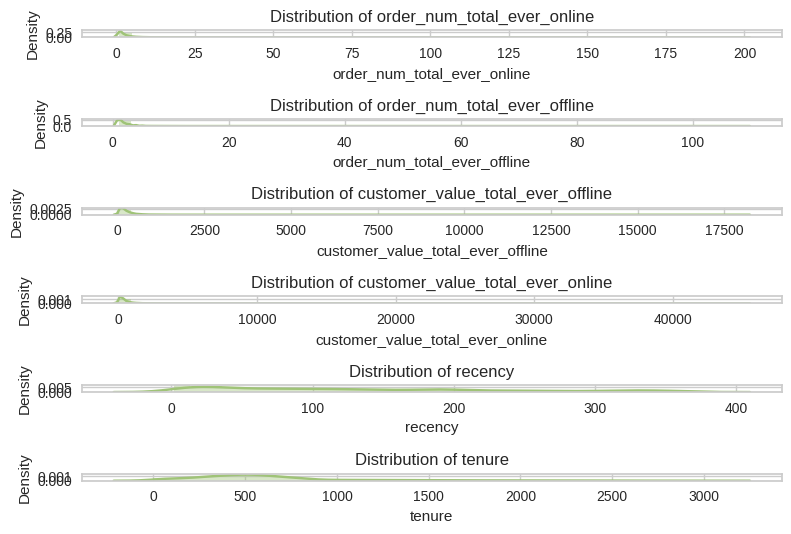

In [21]:
plt.subplot(6, 1, 1)
check_skew(model_df, "order_num_total_ever_online")
plt.subplot(6, 1, 2)
check_skew(model_df, "order_num_total_ever_offline")
plt.subplot(6, 1, 3)
check_skew(model_df, "customer_value_total_ever_offline")
plt.subplot(6, 1, 4)
check_skew(model_df, "customer_value_total_ever_online")
plt.subplot(6, 1, 5)
check_skew(model_df, "recency")
plt.subplot(6, 1, 6)
check_skew(model_df, "tenure")
plt.tight_layout()
plt.savefig('skew.png', format='png', dpi=1000)
plt.show()

# çarpıklık var mı yok mu görsel olarak bakıyoruz

In [22]:
# normal dağılım için log transformation uygulaması
model_df["order_num_total_ever_online"] = np.log1p(model_df["order_num_total_ever_online"])
model_df["order_num_total_ever_offline"] = np.log1p(model_df["order_num_total_ever_offline"])
model_df["customer_value_total_ever_offline"] = np.log1p(model_df["customer_value_total_ever_offline"])
model_df["customer_value_total_ever_online"] = np.log1p(model_df["customer_value_total_ever_online"])
model_df["recency"] = np.log1p(model_df["recency"])
model_df["tenure"] = np.log1p(model_df["tenure"])
model_df.head()

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure
0,1.61,0.69,4.95,6.69,4.56,4.79
1,3.00,1.10,5.08,7.53,4.66,7.29
2,1.39,1.10,5.25,5.98,5.23,5.91
3,0.69,0.69,3.71,4.42,4.91,2.48
4,0.69,0.69,3.93,5.08,4.47,6.37


In [23]:
# scaling işlemleri
sc = MinMaxScaler((0,1))
model_scaling = sc.fit_transform(model_df)
model_df = pd.DataFrame(model_scaling, columns = model_df.columns)
model_df.head()

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure
0,0.20,0.00,0.34,0.50,0.72,0.60
1,0.50,0.10,0.36,0.60,0.74,0.91
2,0.15,0.10,0.39,0.41,0.86,0.74
3,0.00,0.00,0.18,0.22,0.79,0.31
4,0.00,0.00,0.21,0.30,0.70,0.79


In [ ]:
#Optimum Küme Sayısı

In [24]:
from yellowbrick.cluster import KElbowVisualizer

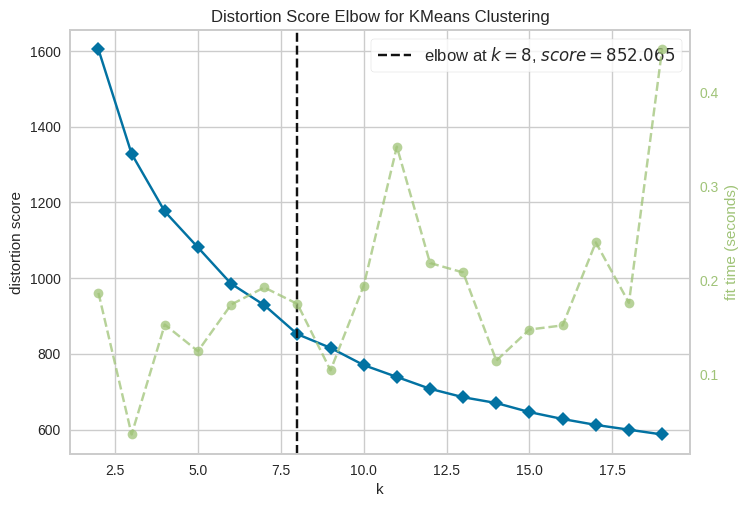

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [25]:
kmeans = KMeans()
elbow = KElbowVisualizer(kmeans, k=(2,20))
elbow.fit(model_df)
elbow.show() # 7

In [ ]:
#Model

In [26]:
k_means = KMeans(n_clusters=7, random_state=42).fit(model_df)
segments = k_means.labels_

final_df = df[["master_id", "order_num_total_ever_online", "order_num_total_ever_offline", "customer_value_total_ever_offline", "customer_value_total_ever_online", "recency", "tenure"]]
final_df["segment"] = segments
final_df.head()

,master_id,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure,segment
0,cc294636-19f0-11eb-8d74-000d3a38a36f,4.00,1.00,139.99,799.38,95,119,3
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,19.00,2.00,159.97,1853.58,105,1469,3
2,69b69676-1a40-11ea-941b-000d3a38a36f,3.00,2.00,189.97,395.35,186,366,3
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.00,1.00,39.99,81.98,135,11,1
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,1.00,1.00,49.99,159.99,86,582,2


In [ ]:
#Her Bir Segmenti İnceleme

In [27]:
final_df.groupby("segment").agg({"order_num_total_ever_online":["mean","min","max"],
                                 "order_num_total_ever_offline":["mean","min","max"],
                                 "customer_value_total_ever_offline":["mean","min","max"],
                                 "customer_value_total_ever_online":["mean","min","max"],
                                 "recency":["mean","min","max"],
                                 "tenure":["mean","min","max","count"]})

order_num_total_ever_online             order_num_total_ever_offline             customer_value_total_ever_offline                 customer_value_total_ever_online                 recency          tenure                
                               mean  min    max                         mean  min    max                              mean    min      max                             mean    min      max    mean min  max   mean min   max count
segment                                                                                                                                                                                                                            
0                              1.43 1.00   5.00                         1.28 1.00   5.00                            144.51  10.00   829.98                           211.86  12.99  1519.17  226.27  88  367 490.58  52  2820  5455
1                              1.40 1.00   8.00                         1.13 1.00   6.00                            192.61  12.99  1333.00                           250.51  19.99  3476.81  139.35   4  367  37.03   0   132   826
2                              1.61 1.00   6.00                         1.48 1.00   6.00                            185.29  12.99  1406.85                           249.82  14.00  1307.33   50.69  15  109 604.32  51  2828  3347
3                              6.46 1.00  55.00                         1.56 1.00  16.00                            187.03  10.49  1644.79                           998.04 180.96 12038.18  178.34  55  367 948.19  26  2964  3239
4                              2.15 1.00  11.00                         2.10 1.00  14.00                            293.96  12.99  3425.14                           369.08  23.99  3444.08   10.08   2   27 660.21   2  2962  1831
5                              1.83 1.00  13.00                         3.76 1.00 109.00                            549.82 106.82 18119.14                           281.82  14.99  2587.20  153.62  22  366 728.58  20  2911  3282
6                              8.57 2.00 200.00                         2.09 1.00  36.00                            279.08  12.99  3589.65                          1469.19 265.97 45220.13   31.79   2  109 966.74  18  3034  1965

In [ ]:
#Hiyerarşik Kümeleme İle Müşteri Segmenti

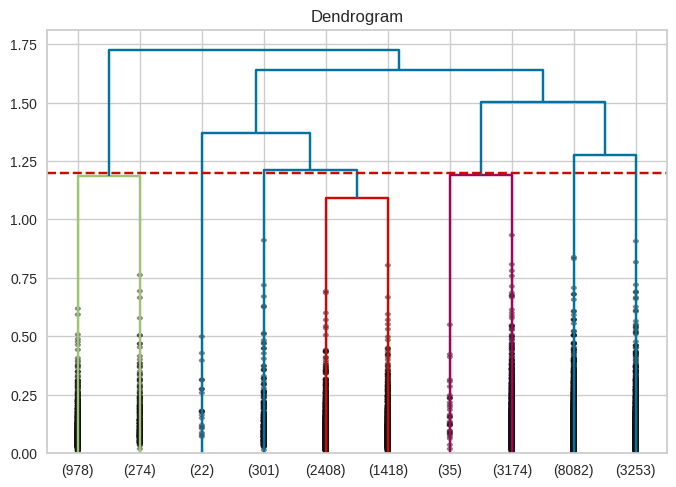

In [28]:
hc_complete = linkage(model_df, "complete")
plt.title("Dendrogram")
dend = dendrogram(hc_complete,
                  truncate_mode="lastp",
                  p=10,
                  show_contracted=True,
                  leaf_font_size=10)
plt.axhline(y=1.2, color='r', linestyle='--')
plt.show()

In [ ]:
#Model

In [29]:
hc = AgglomerativeClustering(n_clusters=5)
segments = hc.fit_predict(model_df)

final_df = df[["master_id", "order_num_total_ever_online", "order_num_total_ever_offline", "customer_value_total_ever_offline", "customer_value_total_ever_online", "recency", "tenure"]]
final_df["segment"] = segments
final_df.head()

,master_id,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure,segment
0,cc294636-19f0-11eb-8d74-000d3a38a36f,4.00,1.00,139.99,799.38,95,119,3
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,19.00,2.00,159.97,1853.58,105,1469,2
2,69b69676-1a40-11ea-941b-000d3a38a36f,3.00,2.00,189.97,395.35,186,366,0
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.00,1.00,39.99,81.98,135,11,3
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,1.00,1.00,49.99,159.99,86,582,0


In [30]:
final_df.groupby("segment").agg({"order_num_total_ever_online":["mean","min","max"],
                                 "order_num_total_ever_offline":["mean","min","max"],
                                 "customer_value_total_ever_offline":["mean","min","max"],
                                 "customer_value_total_ever_online":["mean","min","max"],
                                 "recency":["mean","min","max"],
                                 "tenure":["mean","min","max","count"]})

order_num_total_ever_online             order_num_total_ever_offline             customer_value_total_ever_offline                customer_value_total_ever_online                 recency          tenure                 
                               mean  min    max                         mean  min    max                              mean   min      max                             mean    min      max    mean min  max   mean  min   max count
segment                                                                                                                                                                                                                            
0                              1.37 1.00  13.00                         1.99 1.00 109.00                            261.97 10.49 18119.14                           208.07  12.99 30688.47  183.03  18  367 569.72    3  2911  8747
1                              3.75 1.00  49.00                         1.82 1.00  24.00                            240.98 12.99  3425.14                           638.61  19.99 12545.37   23.96   2  108 715.07   18  3034  4994
2                              6.91 1.00 200.00                         3.08 1.00  16.00                            427.12 12.99  2963.24                          1104.12 139.98 45220.13  131.57  14  365 914.49  109  3016  2396
3                              1.40 1.00   6.00                         1.20 1.00   6.00                            200.69 12.99  1019.97                           227.42  26.99  1389.60   92.52   4  367  80.26    0   555   985
4                              4.74 1.00  24.00                         1.12 1.00   4.00                            123.46 10.00  1049.92                           722.77  59.98  7665.28  196.52  36  367 876.95   71  2964  2823